In [382]:
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score,roc_auc_score
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler, NeighbourhoodCleaningRule
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


def data_import_save(url =  "https://raw.githubusercontent.com/alura-cursos/ML_Classificacao_por_tras_dos_panos/main/Dados/Customer-Churn.csv", 
                         savepath = '..\\src\\data\\churn_detection_raw.csv'):
    df_temp = pd.read_csv(url)
    df_temp.to_csv(savepath)
    return df_temp

# a function that returns each colum unique values, whit the amount of uniques
def info_dados(df):
    columns = df.columns
    values = []
    for column in columns:
        values.append([column,str(df[column].dtype),df[column].unique().shape[0]])
        print(f'Column: {column}')
        print(df[column].unique(), f'Shape: {df[column].unique().shape[0]}', df[column].dtype)
    return values
        
# procura coluna com numeros inteiros que tenham apenas zeros e uns e os transforma em uint8
def zeroum_to_uint8(df):
    for column in df.columns:
        if (str(df[column].dtype).startswith('int') or str(df[column].dtype).startswith('float')) and df[column].unique().sum() == 1:
            df[column] = df[column].astype('uint8')
        

In [482]:
df_raw.ServicoDeInternet.unique()

array(['DSL', 'FibraOptica', 'Nao'], dtype=object)

In [383]:
df_raw = data_import_save()
df = pd.get_dummies(df_raw,drop_first=True)
df.head()

,Maior65Anos,MesesDeContrato,ContaMensal,Conjuge_Sim,Dependentes_Sim,TelefoneFixo_Sim,VariasLinhasTelefonicas_SemServicoTelefonico,VariasLinhasTelefonicas_Sim,ServicoDeInternet_FibraOptica,ServicoDeInternet_Nao,...,TVaCabo_Sim,StreamingDeFilmes_SemServicoDeInternet,StreamingDeFilmes_Sim,TipoDeContrato_Mensalmente,TipoDeContrato_UmAno,PagamentoOnline_Sim,FormaDePagamento_ChequeDigital,FormaDePagamento_ChequePapel,FormaDePagamento_DebitoEmConta,Churn_Sim
0,0,1,29.85,1,0,0,1,0,0,0,...,0,0,0,1,0,1,1,0,0,0
1,0,34,56.95,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0,2,53.85,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,1,0,1
3,0,45,42.30,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,2,70.70,0,0,1,0,0,1,0,...,0,0,0,1,0,1,1,0,0,1


In [384]:
total_perdido = df_raw.groupby('Churn').sum().iloc[1][2]
print(f'O total perdido devido a saída de clientes é: R$ {total_perdido}')

O total perdido devido a saída de clientes é: R$ 139130.85


In [385]:
infodados = pd.DataFrame(info_dados(df_raw),columns=['Colunas','Tipo_Dado','Qtde_Unicos'])

Column: Maior65Anos
[0 1] Shape: 2 int64
Column: Conjuge
['Sim' 'Nao'] Shape: 2 object
Column: Dependentes
['Nao' 'Sim'] Shape: 2 object
Column: MesesDeContrato
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39] Shape: 73 int64
Column: TelefoneFixo
['Nao' 'Sim'] Shape: 2 object
Column: VariasLinhasTelefonicas
['SemServicoTelefonico' 'Nao' 'Sim'] Shape: 3 object
Column: ServicoDeInternet
['DSL' 'FibraOptica' 'Nao'] Shape: 3 object
Column: SegurancaOnline
['Nao' 'Sim' 'SemServicoDeInternet'] Shape: 3 object
Column: BackupOnline
['Sim' 'Nao' 'SemServicoDeInternet'] Shape: 3 object
Column: SeguroNoDispositivo
['Nao' 'Sim' 'SemServicoDeInternet'] Shape: 3 object
Column: SuporteTecnico
['Nao' 'Sim' 'SemServicoDeInternet'] Shape: 3 object
Column: TVaCabo
['Nao' 'Sim' 'SemServicoDeInternet'] Shape: 3 object
Column: Streamin

In [386]:
import plotly.figure_factory as ff
fig = ff.create_table(infodados)
fig.update_layout(
                autosize=False,
                width=450,
                height=200,
                )

fig.write_image("../figs/table_plotly.png", scale=5)

é importante destacar que os clientes que não tem serviço online automaticamente não teriam os serviços relacionados e portanto poderiam se relacionar de forma direta ao "Não" dos dados.  
Uma análise de correlação entre essa variável "Sem serviço de internet" e o Churn pode ajudar a decidir

In [387]:
df_raw.describe(include = "all")

,Maior65Anos,Conjuge,Dependentes,MesesDeContrato,TelefoneFixo,VariasLinhasTelefonicas,ServicoDeInternet,SegurancaOnline,BackupOnline,SeguroNoDispositivo,SuporteTecnico,TVaCabo,StreamingDeFilmes,TipoDeContrato,PagamentoOnline,FormaDePagamento,ContaMensal,Churn
count,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,2
top,NaN,Nao,Nao,NaN,Sim,Nao,FibraOptica,Nao,Nao,Nao,Nao,Nao,Nao,Mensalmente,Sim,ChequeDigital,NaN,Nao
freq,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,5174
mean,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


In [388]:
print('A quantidade total de nulos nesse banco de dados é: ',df.isna().sum().sum())

A quantidade total de nulos nesse banco de dados é:  0


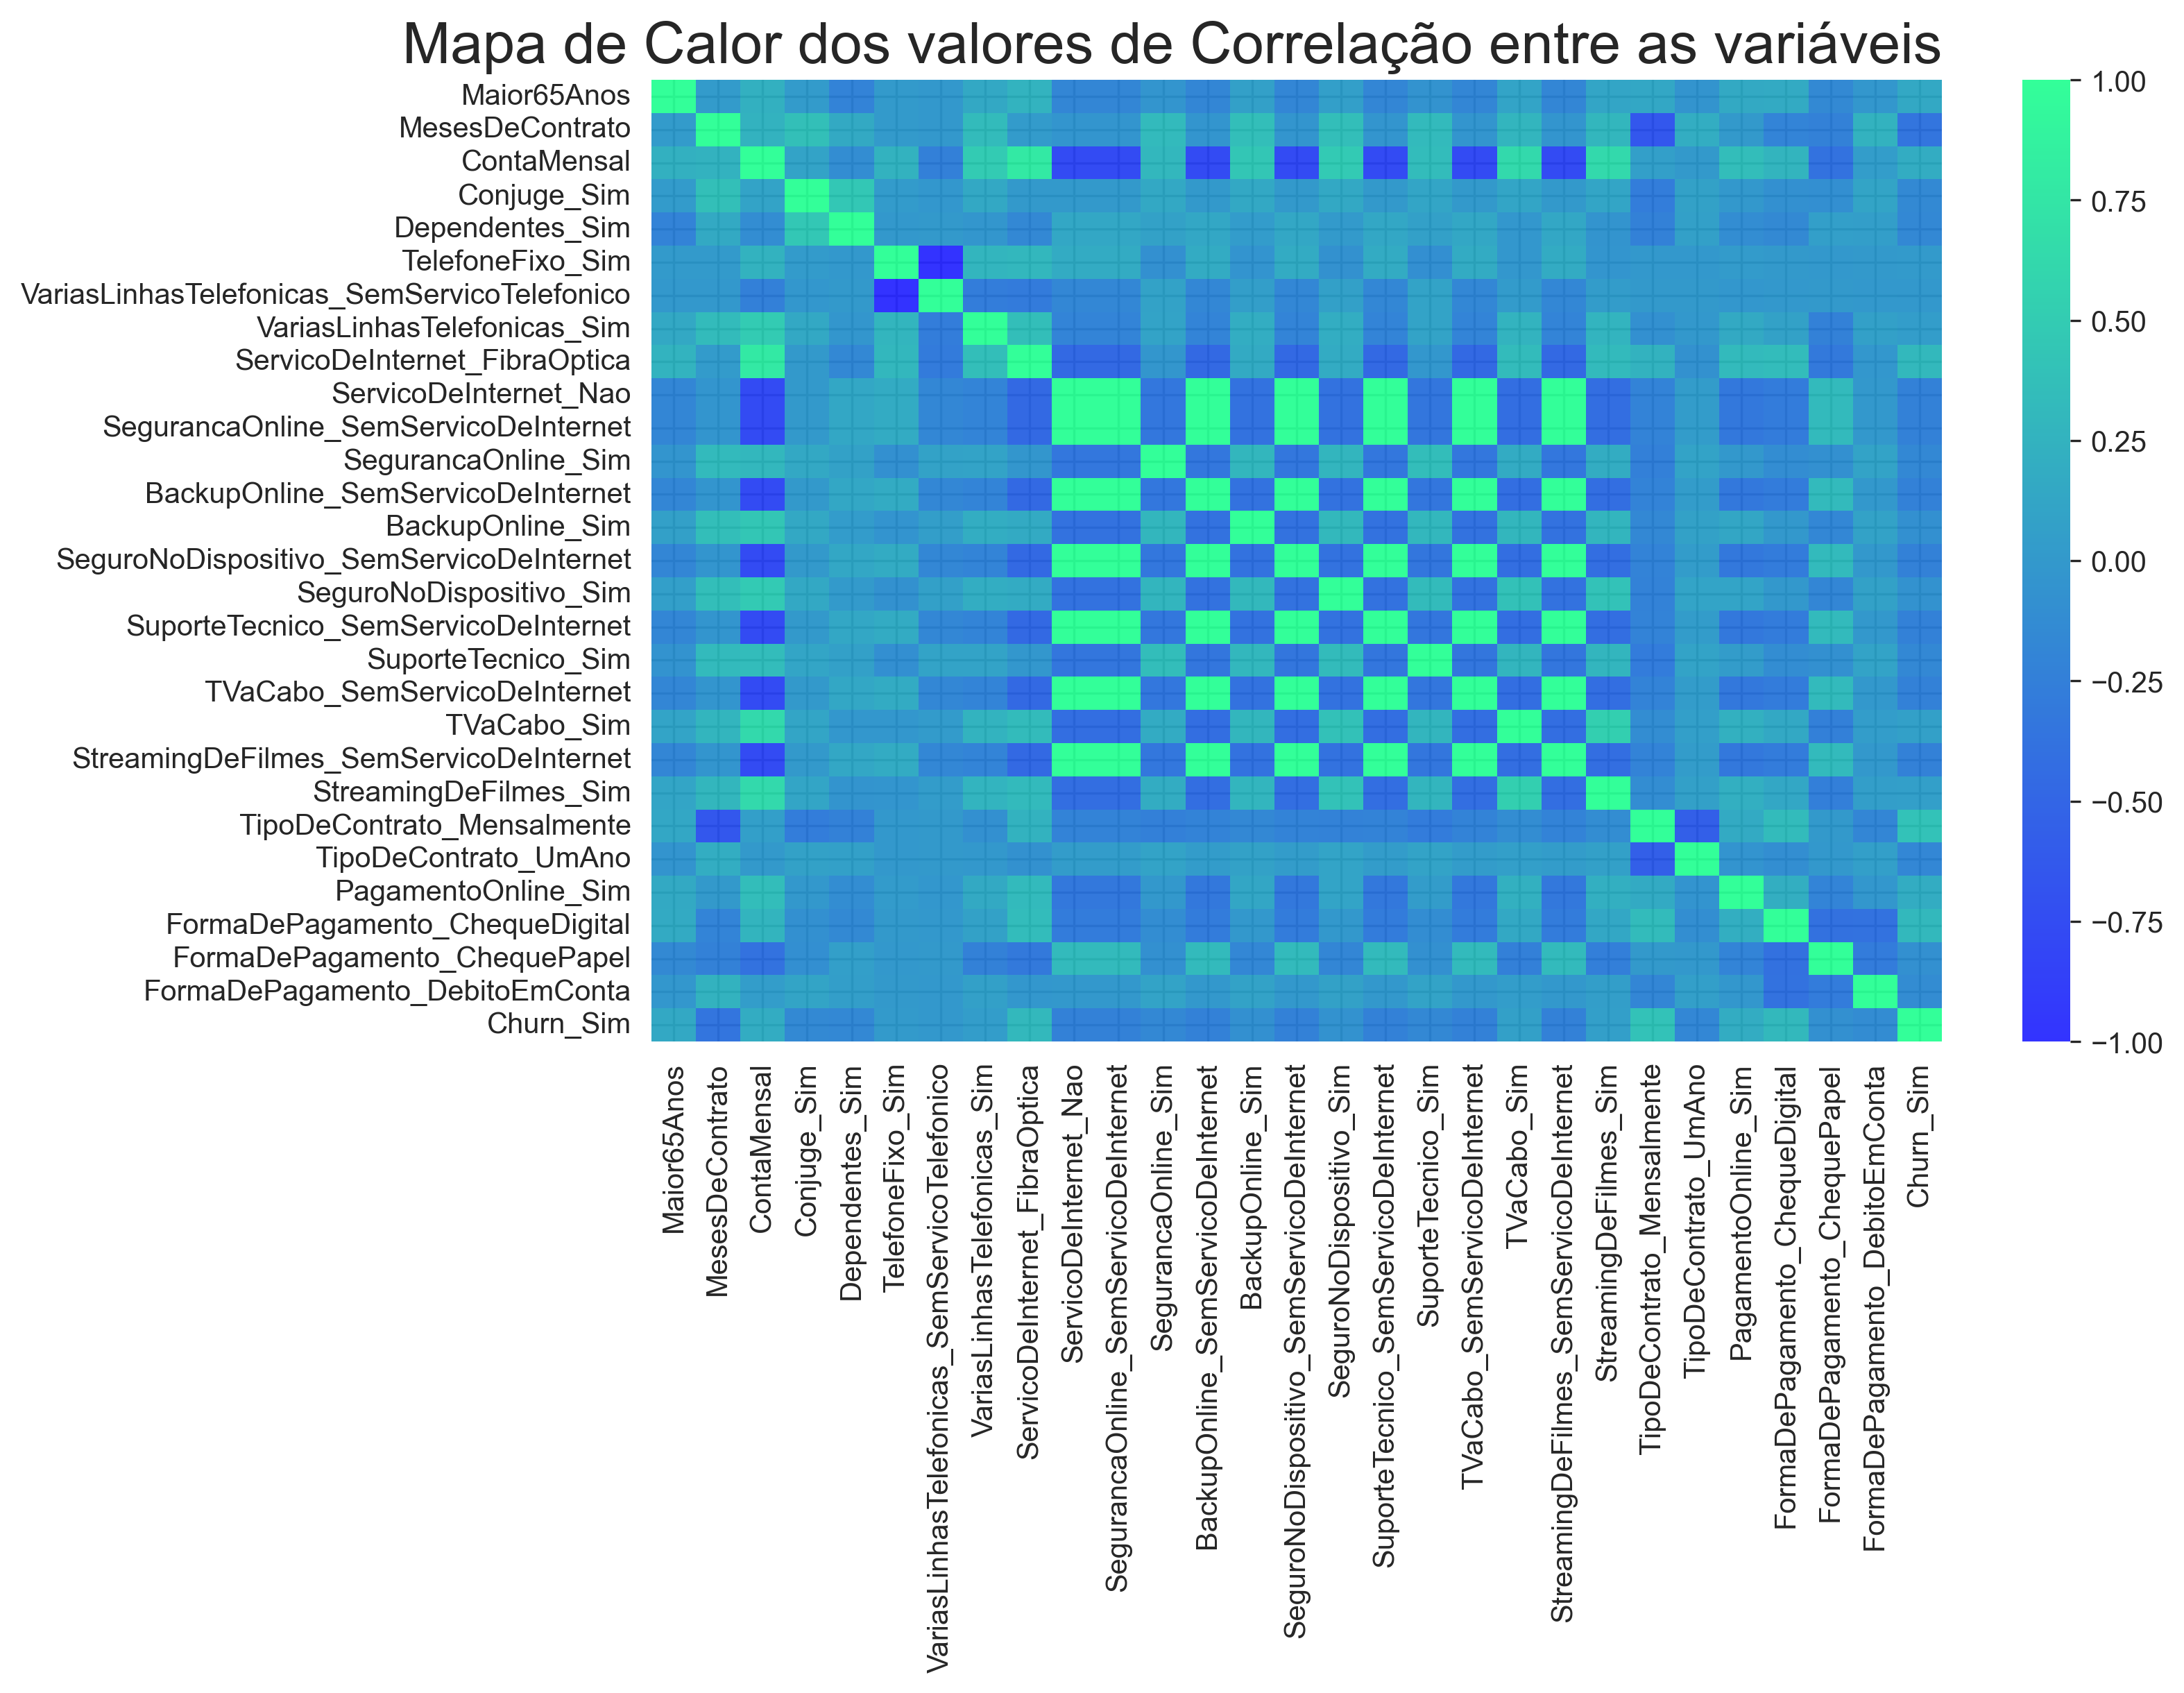

In [389]:
plt.figure(figsize=(10,6), dpi=300)
fig = sns.heatmap(df.corr(),xticklabels=1, yticklabels=1, cmap='winter', alpha=0.8 )
plt.title('Mapa de Calor dos valores de Correlação entre as variáveis',fontdict={'fontsize':20}, loc='right')
plt.savefig('../figs/heatmap.png', bbox_inches='tight', dpi=300)
plt.show()

A pesar de de apresentarem uma correlação fraca +- 0,2, há uma diferença entre o cliente não ter o serviço e ele ter e apenas optar por não assinar o serviço.

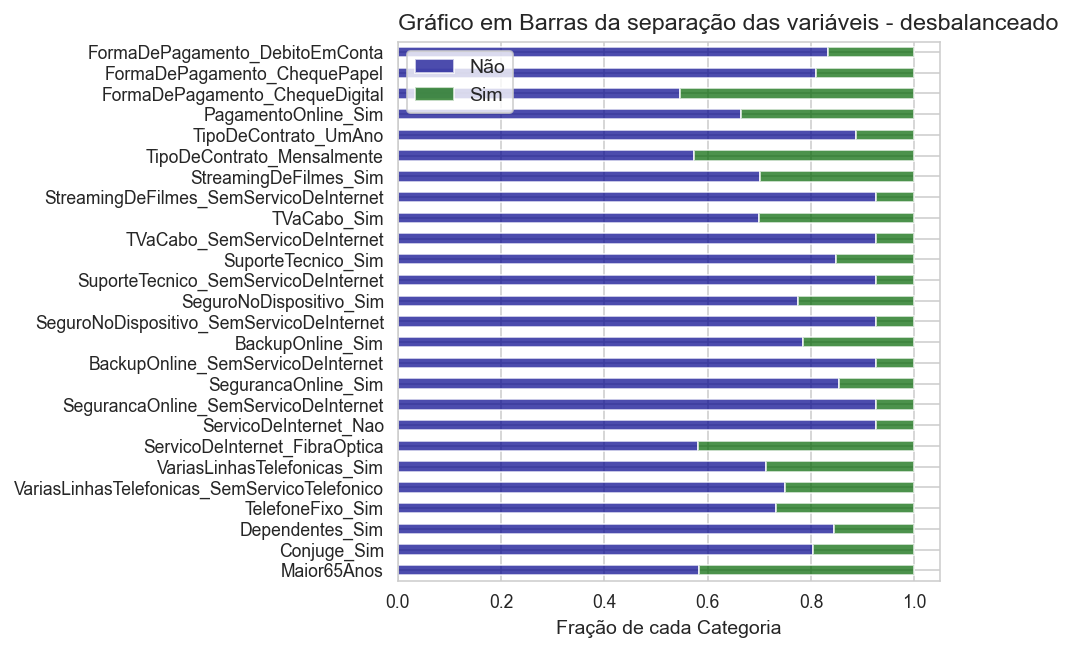

In [390]:
#Plot doas variáveis apenas com sim e não para ver se elas dividem o dataset, DESBALANCEADO

# transforma as variáveis zero e um para o formato unint8
zeroum_to_uint8(df)

# Cria um agrupamento de todas as variáveis categoricas
A = df.select_dtypes(include = 'uint8').groupby(df.Churn_Sim, sort = False).sum()
A = A.div(df.select_dtypes(include = 'uint8').sum(axis=0), axis=1).rename_axis('Cliente_Saiu').T
A = A

plt.rcParams["figure.dpi"] = 140
# sns.set_style('whitegrid')
A.columns = ['Não', 'Sim']
A.drop('Churn_Sim').plot(kind="barh", rot=0, stacked=True,figsize=(5,5), 
                         alpha=0.7, color=['darkblue','darkgreen'])
# A.plot()
plt.tick_params(labelsize=9)
plt.xlabel('Fração de cada Categoria')
plt.title('Gráfico em Barras da separação das variáveis - desbalanceado',loc='left')
plt.savefig('../figs/barplot_desbal.png', dpi=300,bbox_inches='tight' )
plt.show()



# Balanceamento de dados

O banco de dados está desbalanceado quanto ao Churn, um balanceamento por oversampling será feito com o RandomSampler

In [391]:
# conferindo o balanceamento da target
df.Churn_Sim.value_counts()

0    5174
1    1869
Name: Churn_Sim, dtype: int64

In [392]:
rands = RandomUnderSampler()

In [393]:
y = df.Churn_Sim
X = df.drop('Churn_Sim', axis=1)
X, y = rands.fit_resample(X, y)

In [394]:
# conferindo a atarget balanceada pelo RandomSampler
y.value_counts()

0    1869
1    1869
Name: Churn_Sim, dtype: int64

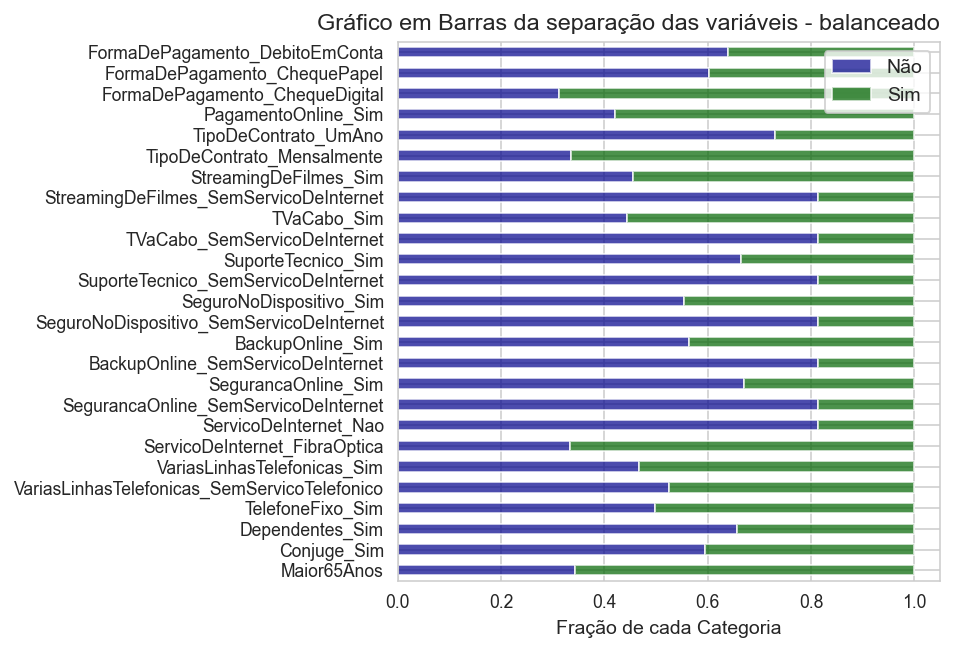

In [395]:
zeroum_to_uint8(X)

# Agrupa os dados binados e os somas de acordo com a categoria, dividindo em seguida para normalizar os valores
A = X.select_dtypes(include = 'uint8').groupby([y], sort = False).sum()
A = A.div(X.select_dtypes(include = 'uint8').sum(axis=0), axis=1)
A = A.T
# Faz o plot dos dados em barras horizontais de forma normalizada para observar a divisão do targuet entre os dados
plt.rcParams["figure.dpi"] = 140
sns.set_style('whitegrid')
A.columns = ['Não', 'Sim']
A.plot(kind="barh", rot=0, stacked=True,
       color=['darkblue','darkgreen'],figsize=(5,5), alpha=0.7)
plt.tick_params(labelsize=9)
plt.xlabel('Fração de cada Categoria')
plt.title('Gráfico em Barras da separação das variáveis - balanceado',loc='right')
plt.savefig('../figs/barplot_bal.png', dpi=300,bbox_inches='tight' )
plt.show()

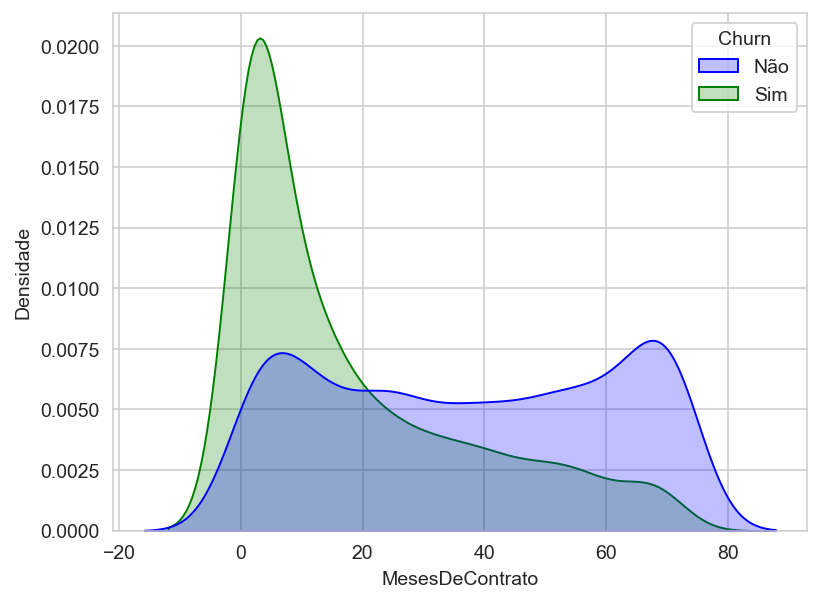

In [396]:
tmp = X.copy()
tmp['Churn']=y
tmp['Churn'] = tmp['Churn'].replace([0,1],['Não','Sim'])
plt.ylabel('Densidade')
sns.kdeplot(data=tmp,x='MesesDeContrato', hue='Churn', fill=True, palette=['blue','green'] )
plt.savefig('../figs/dens_plot_meses.png', dpi=300,bbox_inches='tight' )
plt.show()

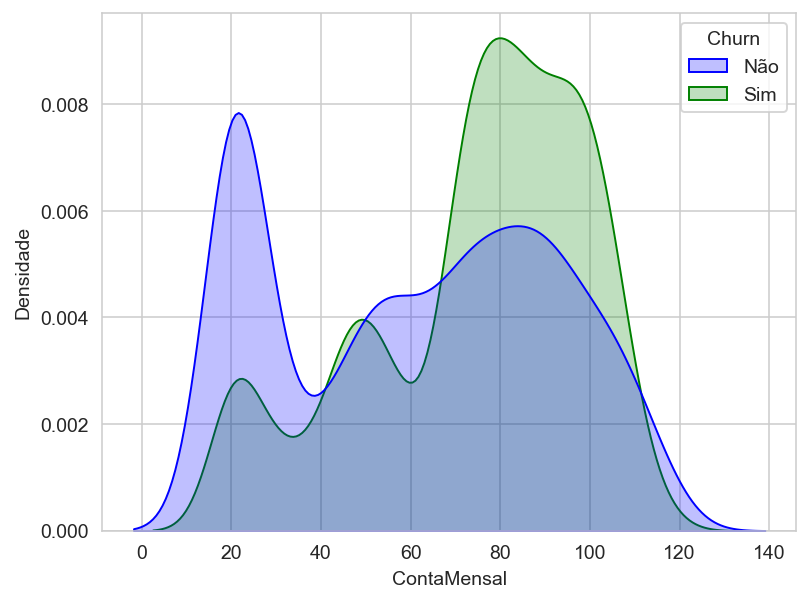

In [397]:
plt.ylabel('Densidade')
sns.kdeplot(data=tmp,x='ContaMensal', hue='Churn', fill=True, palette=['blue','green'])
plt.savefig('../figs/dens_plot_conta.png', dpi=300,bbox_inches='tight' )
plt.show()

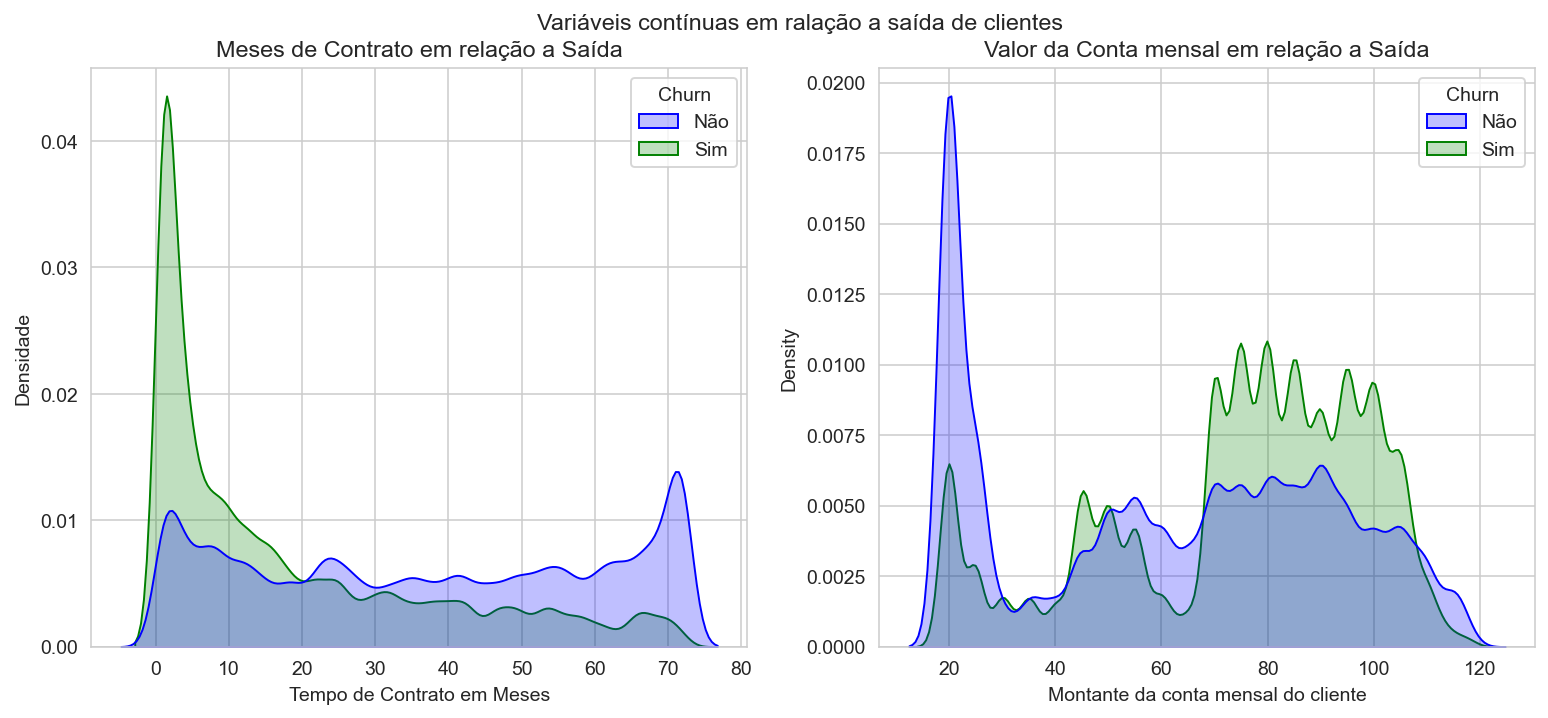

In [398]:
# Creating 2 subplots 

fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2)
fig.suptitle('Variáveis contínuas em ralação a saída de clientes')
fig.set_figheight(5)
fig.set_figwidth(11)
fig.tight_layout(w_pad=4)

ax1.set_title('Meses de Contrato em relação a Saída')
sns.kdeplot(ax=ax1,data=tmp,x='MesesDeContrato', hue='Churn', fill=True, palette=['blue','green'],bw_adjust=0.3)
ax1.set_xlabel('Tempo de Contrato em Meses')
ax1.set_ylabel('Densidade')


ax2.set_title('Valor da Conta mensal em relação a Saída')
sns.kdeplot(ax=ax2,data=tmp,x='ContaMensal', hue='Churn', fill=True, palette=['blue','green'],bw_adjust=0.3)
ax2.set_xlabel('Montante da conta mensal do cliente')
ax1.set_ylabel('Densidade')


plt.savefig('../figs/kdplot_meses_valorconta.png',dpi=300, bbox_inches='tight')
plt.show()

In [400]:
tmp = X.copy()
tmp['Churn']=y
tmp['Churn'] = tmp['Churn'].replace([0,1],['Não','Sim'])

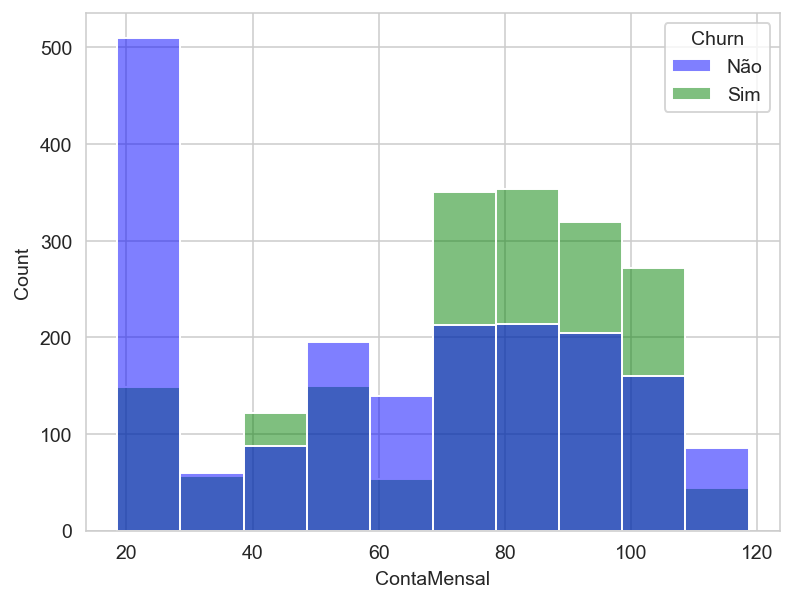

In [401]:
tmp = X.select_dtypes(exclude="uint8")
tmp['Churn']=y
tmp['Churn'] = tmp['Churn'].replace([0,1],['Não','Sim'])
sns.histplot(tmp,x='ContaMensal',hue='Churn', palette=['blue','green'],bins=10)
plt.show()

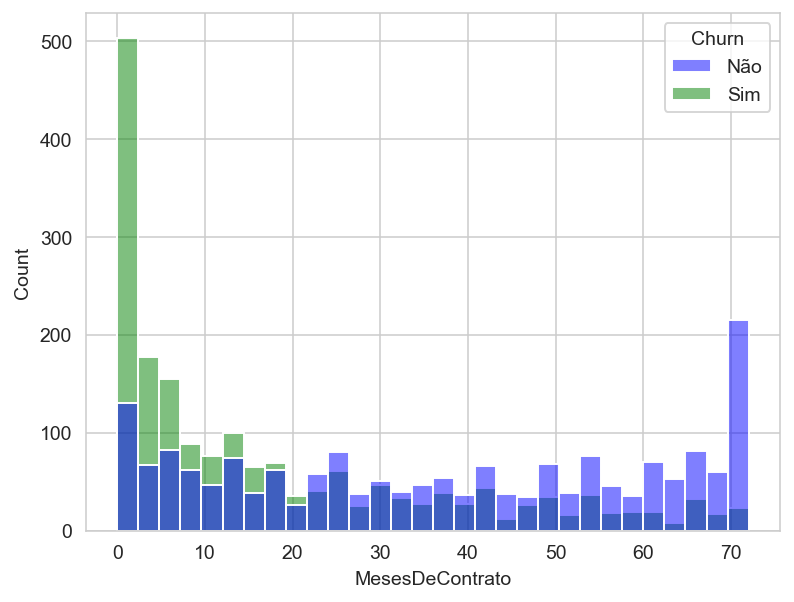

In [402]:
tmp = X.select_dtypes(exclude="uint8")
tmp['Churn']=y
tmp['Churn'] = tmp['Churn'].replace([0,1],['Não','Sim'])
sns.histplot(tmp,x='MesesDeContrato',hue='Churn', palette=['blue','green'], bins = 30)
plt.show()

# Comparação entre os modelos

O objetivo da análise é detectar os clientes mais provávei de deixarem a empresa e intervir e oferecer um produto.
Para isso, uma opção é avaliar seria avaliar a precisão, porém o score F1 e a área abaixo da curva ROC são melhores.

In [420]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)


# Definindo a Árvore de decisão com profundidade máxima e com critério 
tree = DecisionTreeClassifier(criterion='entropy', max_depth=6)
tree.fit(X_train,y_train)


lr = LogisticRegression(penalty='elasticnet',solver='saga', l1_ratio=0.5)
lr.fit(X_train,y_train)

LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga')

In [421]:
print('O score F1 do KNN é:',f1_score(y_test,knn.predict(X_test)))
print('O score F1 do Árvore de Decisão é:',f1_score(y_test,tree.predict(X_test)))
print('O score F1 da Regressão Logistica é:',f1_score(y_test,lr.predict(X_test)))

O score F1 do KNN é: 0.5452261306532663
O score F1 do Árvore de Decisão é: 0.5217391304347826
O score F1 da Regressão Logistica é: 0.6062992125984252


In [422]:
print('O score AUC ROC do KNN é:',roc_auc_score(y_test,knn.predict(X_test)))
print('O score AUC ROC do Árvore de Decisão é:',roc_auc_score(y_test,tree.predict(X_test)))
print('O score F1 da Regressão Logistica é:',roc_auc_score(y_test,lr.predict(X_test)))

O score AUC ROC do KNN é: 0.6926753711797893
O score AUC ROC do Árvore de Decisão é: 0.676805234729891
O score F1 da Regressão Logistica é: 0.7308173683803766


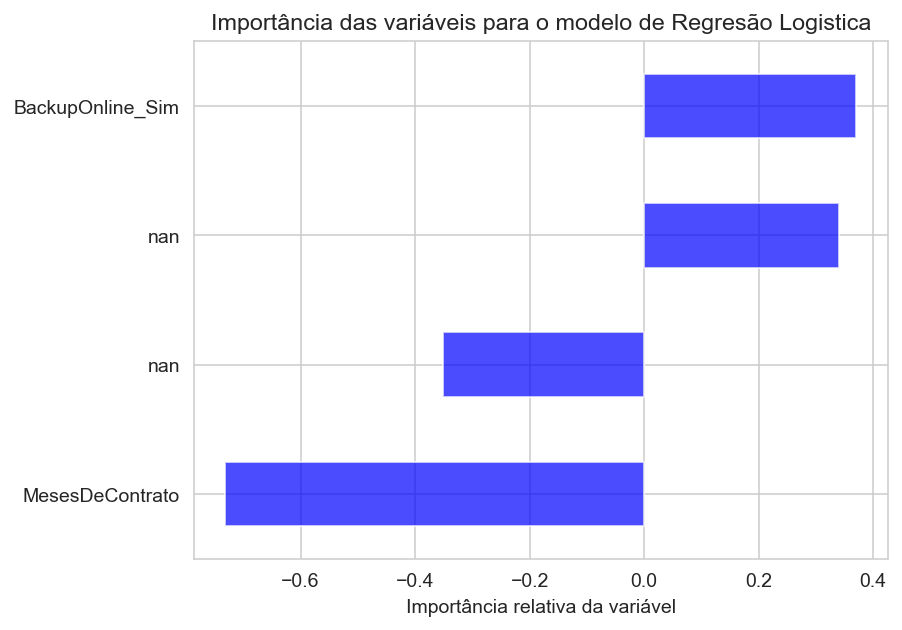

In [423]:
# Construindo a tabela com a importância de variáveis da Árvore de Decisão
a = pd.DataFrame([df.drop('Churn_Sim', axis=1).columns.tolist(),
                  lr.coef_[0].tolist()]).T.set_index(0).sort_values(by = 1,ascending=False)
# Construindo o Gráfico
a.loc[(a[1]>=0.3)|(a[1]<=-0.3)].sort_values(1).plot(kind = 'barh',legend = None, cmap='winter', alpha=0.7)
plt.title('Importância das variáveis para o modelo de Regresão Logistica' )
plt.xlabel('Importância relativa da variável')
plt.ylabel(None)
plt.savefig('../figs/var_import_logistica.png', dpi=300,bbox_inches='tight' )
plt.show()

# Inclusão da Pipeline

In [407]:
# Substituindo sim e nao por valores boleanos
df_raw['Churn'] = df_raw.Churn.replace({'Nao':0,'Sim':1})

# separando os dados brutos em Treino e Teste Para não vazar informação nos imputs
df_train, df_test = train_test_split(df_raw, test_size=0.33, random_state=42)

# criando listas de colunas que tenham valores numeticos e objetos
lista_num = [col for col in df_raw.drop('Churn',axis=1).columns if 'object' not in str(df_raw[col].dtype)]
lista_obj = [col for col in df_raw.drop('Churn',axis=1).columns if 'object' in str(df_raw[col].dtype)]

#definindo o encoder para codificar as categorias e o scaler para normalizar as vriáveis numéricas
encoder = OneHotEncoder()
scaler = StandardScaler()

# definindo o tipo de balanceamento que será feito
balancer = SMOTE()

#definindo o modelo
model = lr

# definindo os pacos da pipeline de preprocessamento
steps_num = [('scaler',scaler)]
steps_cat = [('encoder',encoder)]

# Definindo a pipelinde de preprocessamento numerica e categorica
pipe_num = Pipeline(steps_num)
pipe_cat = Pipeline(steps_cat)

# Definindo a pipeline de preprocessamentro completa
pre_process = ColumnTransformer(transformers=[('num', pipe_num,lista_num),('cat',pipe_cat,lista_obj)])


# Definindo os pacos da pipeline
step = [('pre_process',pre_process),('balancer',balancer),('model',model)]

# Definindo a pipeline que teá os passos do step
pipe = Pipeline(step)

# Fazendo o fit nos dados de treino
pipe.fit(df_train,df_train.Churn)

# Fazendo o Predict e já retornando os scores            
score = roc_auc_score(df_test.Churn,pipe.predict(df_test))
score_f1 = f1_score(df_test.Churn,pipe.predict(df_test))
print('A área sobre a curva ROC é {:.4f}'.format(score))
print('O score F1 é {:.4f}'.format(score_f1))



A área sobre a curva ROC é 0.7796
O score F1 é 0.6498


## usando a Pipeline para avaliar diferentes balanceadores e diferentes modelos

In [455]:
# separando os dados brutos em Treino e Teste Para não vazar informação nos imputs
df_train, df_test = train_test_split(df_raw, test_size=0.33, random_state=42)

# criando listas de colunas que tenham valores numeticos e objetos
lista_num = [col for col in df_raw.drop('Churn',axis=1).columns if 'object' not in str(df_raw[col].dtype)]
lista_obj = [col for col in df_raw.drop('Churn',axis=1).columns if 'object' in str(df_raw[col].dtype)]

#definindo o encoder para codificar as categorias e o scaler para normalizar as vriáveis numéricas
encoder = OneHotEncoder()
scaler = StandardScaler()

# definindo o tipo de balanceamento que será feito
balancer = SMOTE()

#definindo o modelo
model = lr

# definindo os pacos da pipeline de preprocessamento
steps_num = [('scaler',scaler)]
steps_cat = [('encoder',encoder)]

# Definindo a pipelinde de preprocessamento numerica e categorica
pipe_num = Pipeline(steps_num)
pipe_cat = Pipeline(steps_cat)

# Definindo a pipeline de preprocessamentro completa
pre_process = ColumnTransformer(transformers=[('num', pipe_num,lista_num),('cat',pipe_cat,lista_obj)])

# Definindo a lista de modelos que serão testados e definindo seus hiperparâmetros
lista_modelo = [KNeighborsClassifier(n_neighbors=8),
                LogisticRegression(penalty='elasticnet', solver='saga',C=0.9, l1_ratio=0.5),
                DecisionTreeClassifier(max_depth=5), 
                RandomForestClassifier(max_depth=5, n_estimators=60),
                GradientBoostingClassifier(n_estimators=30)]

# Definindo a lista de tecnicas de balanceamento de dados a serem testadas
# lista_balancer = [SMOTE(),RandomUnderSampler(),NeighbourhoodCleaningRule(n_neighbors=5)]
lista_balancer = [RandomUnderSampler()]

# Executando um loop que vai passar por diversos modelos e testar os diferentes balanceamentos e cada modelo
for model in lista_modelo:
    for balancer in lista_balancer:
        step = [('pre_process',pre_process),('balancer',balancer),('model',model)]

        pipe = Pipeline(step)
        pipe.fit(df_train,df_train.Churn)
            
        score = roc_auc_score(df_test.Churn,pipe.predict(df_test))
        score_f1 = f1_score(df_test.Churn,pipe.predict(df_test))
        print(model, balancer, 'ROC_AUC Score: {:.4f}'.format(score),'F1 Score: {:.4f}'.format(score_f1))
        print(model, balancer, 'ROC_AUC Score: {:.4f}'.format(roc_auc_score(df_train.Churn,pipe.predict(df_train))),
              'F1 Score: {:.4f}'.format(f1_score(df_train.Churn,pipe.predict(df_train))))
    print('')
        

KNeighborsClassifier(n_neighbors=8) RandomUnderSampler() ROC_AUC Score: 0.7538 F1 Score: 0.6166
KNeighborsClassifier(n_neighbors=8) RandomUnderSampler() ROC_AUC Score: 0.7634 F1 Score: 0.6242

LogisticRegression(C=0.9, l1_ratio=0.5, penalty='elasticnet', solver='saga') RandomUnderSampler() ROC_AUC Score: 0.7769 F1 Score: 0.6437
LogisticRegression(C=0.9, l1_ratio=0.5, penalty='elasticnet', solver='saga') RandomUnderSampler() ROC_AUC Score: 0.7538 F1 Score: 0.6124

DecisionTreeClassifier(max_depth=5) RandomUnderSampler() ROC_AUC Score: 0.7582 F1 Score: 0.6252
DecisionTreeClassifier(max_depth=5) RandomUnderSampler() ROC_AUC Score: 0.7632 F1 Score: 0.6271

RandomForestClassifier(max_depth=5, n_estimators=60) RandomUnderSampler() ROC_AUC Score: 0.7682 F1 Score: 0.6318
RandomForestClassifier(max_depth=5, n_estimators=60) RandomUnderSampler() ROC_AUC Score: 0.7576 F1 Score: 0.6138

GradientBoostingClassifier(n_estimators=30) RandomUnderSampler() ROC_AUC Score: 0.7797 F1 Score: 0.6436
Gradient

## Usando a pipeline para realizar um gridsearch no melhor modelo e no melhor balanceamento

In [409]:
from sklearn.model_selection import GridSearchCV

In [410]:
# Substituindo sim e nao por valores boleanos
df_raw['Churn'] = df_raw.Churn.replace({'Nao':0,'Sim':1})

# separando os dados brutos em Treino e Teste Para não vazar informação nos imputs
df_train, df_test = train_test_split(df_raw, test_size=0.33, random_state=42)

# criando listas de colunas que tenham valores numeticos e objetos
lista_num = [col for col in df_raw.drop('Churn',axis=1).columns if 'object' not in str(df_raw[col].dtype)]
lista_obj = [col for col in df_raw.drop('Churn',axis=1).columns if 'object' in str(df_raw[col].dtype)]

#definindo o encoder para codificar as categorias e o scaler para normalizar as vriáveis numéricas
encoder = OneHotEncoder()
scaler = StandardScaler()

# definindo o tipo de balanceamento que será feito
balancer = SMOTE()

#definindo o modelo
model = GradientBoostingClassifier(n_estimators=30)

# definindo os pacos da pipeline de preprocessamento
steps_num = [('scaler',scaler)]
steps_cat = [('encoder',encoder)]

# Definindo a pipelinde de preprocessamento numerica e categorica
pipe_num = Pipeline(steps_num)
pipe_cat = Pipeline(steps_cat)

# Definindo a pipeline de preprocessamentro completa
pre_process = ColumnTransformer(transformers=[('num', pipe_num,lista_num),('cat',pipe_cat,lista_obj)])


# Definindo os pacos da pipeline
step = [('pre_process',pre_process),('balancer',balancer),('model',model)]

# Definindo a pipeline que teá os passos do step
pipe = Pipeline(step)

# Definindo a lista de parâmetros
param = {'model__n_estimators':[10,50,100,200], 'model__max_depth':[1,2,3,4]}

# Definindo o Gridsearch com score F1
gcv = GridSearchCV(pipe,scoring='f1',n_jobs=-1, param_grid=param)

# Treinando o gridsearch com dados de treino
gcv.fit(df_train,df_train.Churn)

GridSearchCV(estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Maior65Anos',
                                                                          'MesesDeContrato',
                                                                          'ContaMensal']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['Conjuge',
                                                                          'Dependentes',
                                                                          'TelefoneFixo',
                                                                          'VariasLinhasTelefonicas',
                                                                          'ServicoDeInternet',
                                                                          'SegurancaOnline',
                                                                          'BackupOnline',
                                                                          'SeguroNoDispositivo',
                                                                          'SuporteTecnico',
                                                                          'TVaCabo',
                                                                          'StreamingDeFilmes',
                                                                          'TipoDeContrato',
                                                                          'PagamentoOnline',
                                                                          'FormaDePagamento'])])),
                                       ('balancer', SMOTE()),
                                       ('model',
                                        GradientBoostingClassifier(n_estimators=30))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [1, 2, 3, 4],
                         'model__n_estimators': [10, 50, 100, 200]},
             scoring='f1')

In [411]:
# Retornando a melhor combinanção dos parâmetros avaliados
print('A melhor profundidade foi de ',gcv.best_params_['model__max_depth'])
print('O melhor numero de estimadores foi de ',gcv.best_params_['model__n_estimators'])

# definindo o melhor modelo
melhor_modelo = gcv.best_estimator_

# avaliando o melhor modelo
print('O score F1 dos dados totais de treino é {:.4f}'.format(f1_score(df_train.Churn,melhor_modelo.predict(df_train))))
print('O score F1 dos dados de teste é {:.4f}'.format(f1_score(df_test.Churn,melhor_modelo.predict(df_test))))


A melhor profundidade foi de  2
O melhor numero de estimadores foi de  50
O score F1 dos dados totais de treino é 0.6302
O score F1 dos dados de teste é 0.6511


## Usando SHAP para retornar a importância das variáveis na previsão

In [412]:
import shap

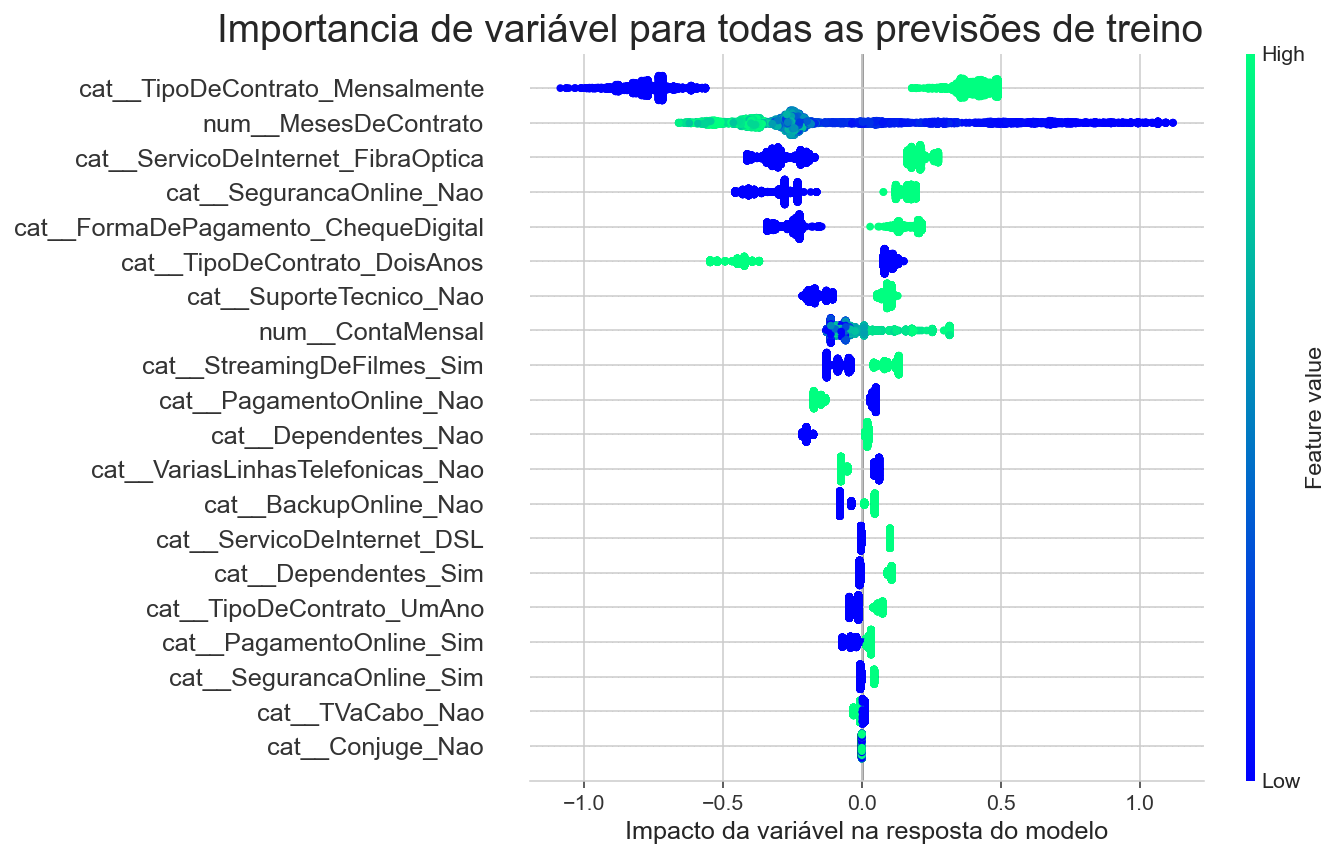

In [463]:
# definindo o modelo de explicação do tipo gradient boost de arvores
explainer = shap.TreeExplainer(melhor_modelo['model'])

# separando os dados brutos em Treino e Teste Para não vazar informação nos imputs
df_train, df_test = train_test_split(df_raw, test_size=0.33, random_state=42)

# separando X e y dos dados de treino e aplicando o preprocessamento da pipeline em X
X = melhor_modelo['pre_process'].transform(df_train)
y = df_train.Churn

# retornando os valores shap do explicador
shap_values = explainer.shap_values(X,y)

# Definindo o nome das variaveis e retornando um gráfico violino das previsões em função do Churn
feature_names=melhor_modelo['pre_process'].get_feature_names_out()
fig, ax = plt.subplots()
fig = shap.summary_plot(
    shap_values, 
    X, 
    feature_names = feature_names,
    plot_type='dot',
    plot_size=(10,6),
    show=False,
    cmap = "winter")
plt.title('Importancia de variável para todas as previsões de treino', loc='right',fontdict={'fontsize':20})
plt.xlabel('Impacto da variável na resposta do modelo')
plt.savefig('../figs/vai_imp_gradient.png', dpi=300,bbox_inches='tight' )
plt.show(fig)




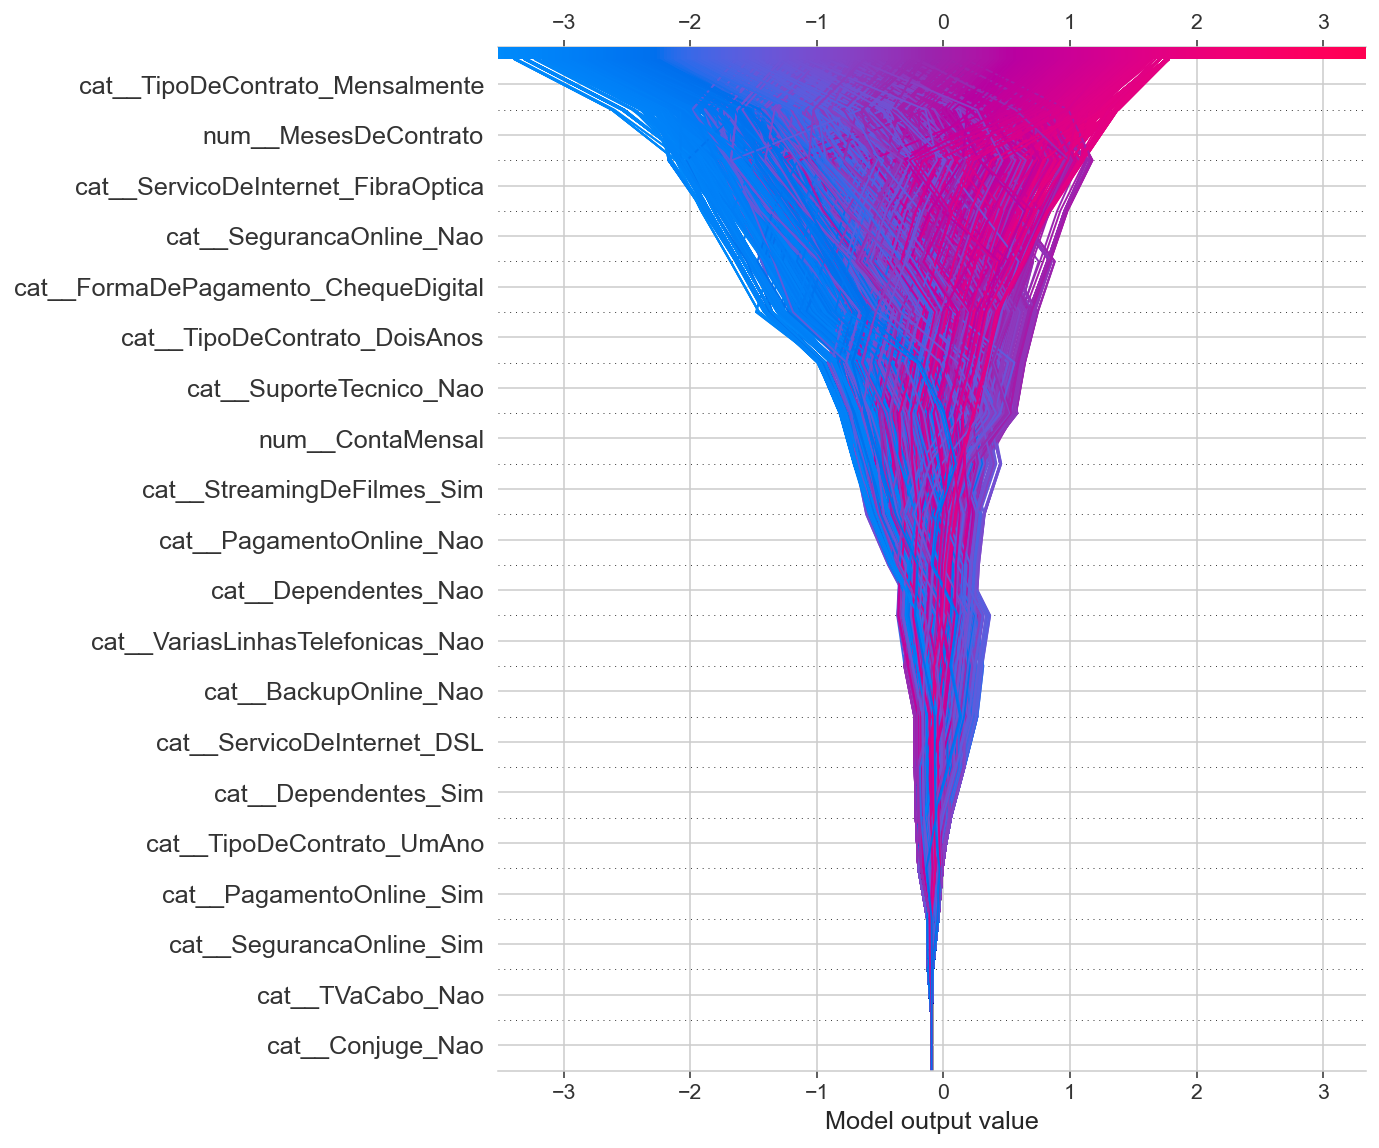

In [475]:
shap.decision_plot(explainer.expected_value, shap_values,feature_names=feature_names, ignore_warnings=True)

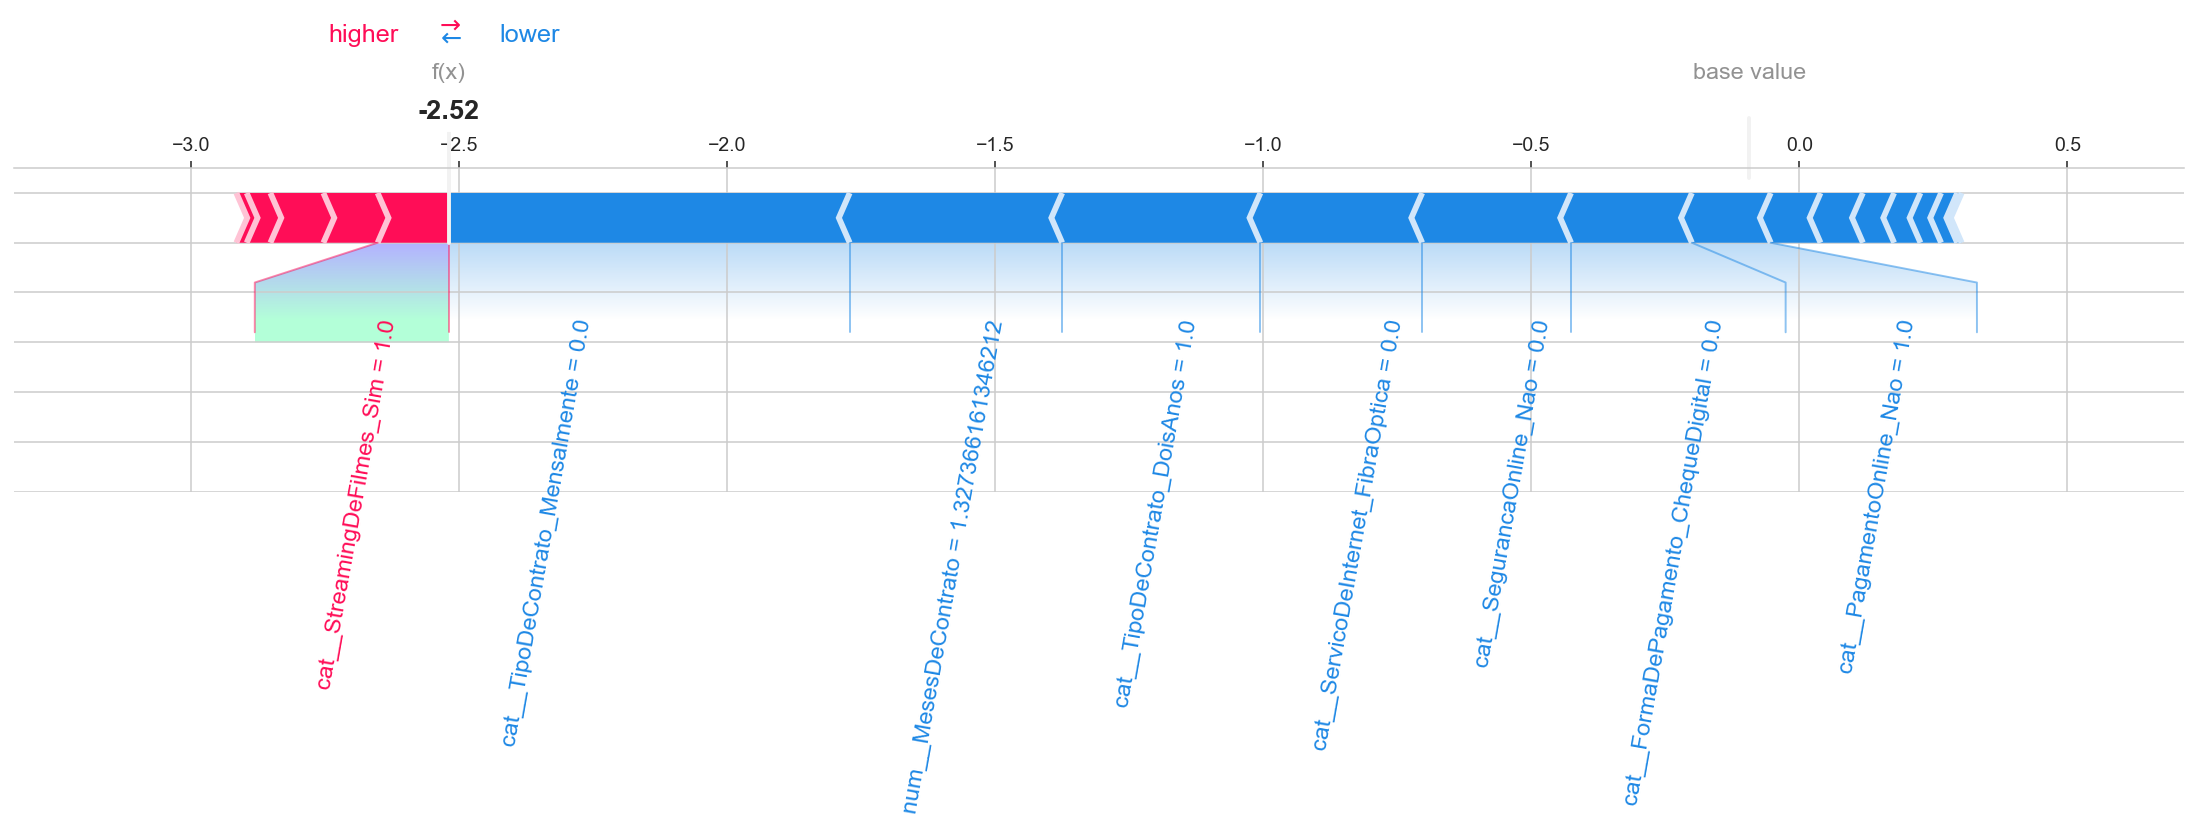

In [414]:
amostra = 500

fig = shap.force_plot(
    explainer.expected_value, 
    shap_values[amostra,:], 
    X[amostra,:], 
    matplotlib=True, 
    feature_names=melhor_modelo['pre_process'].get_feature_names_out(), 
    text_rotation=80, show=False, plot_cmap='winter')
plt.set_cmap('winter')
plt.show(fig)

## Análise de Churn em uma Empresa de Telefonia e Internet

Este é um estudo de caso sobre o problema de churn em uma empresa de telefonia e internet. O churn é a perda de clientes que cancelam seus serviços, e é um problema crítico que pode afetar negativamente a receita e a imagem da marca da empresa.

A empresa oferece serviços de telefonia e internet, incluindo:
> Planos de telefone fixo, de dados móveis e de banda larga.  
> Pacotes de TV a cabo, de Streaming de Filmes e de
> Serviços de Backup Online, Segurança online e Seguro de Dispositivo 

O objetivo é identificar os principais fatores que influenciam a taxa de churn e propor soluções para reduzir essa taxa e reter os clientes.

Os dados foram coletados a partir de várias fontes, incluindo registros de clientes, informações de faturamento e logs de chamadas de suporte. O conjunto de dados contém informações demográficas dos clientes, histórico de pagamentos e uso de serviços.

A análise exploratória dos dados será realizada para identificar padrões e tendências nos dados, bem como relacionamentos entre as variáveis. Em seguida, serão aplicadas técnicas de modelagem preditiva para prever a taxa de churn e identificar os principais fatores que contribuem para essa taxa. 

Também serão propostas soluções para reduzir a taxa de churn, como melhorar a qualidade do serviço, ajustar preços, oferecer promoções e incentivos de fidelização, e melhorar o atendimento ao cliente. O resultado esperado é fornecer insights valiosos sobre o problema de churn em uma empresa de telefonia e internet e fornecer recomendações práticas para reduzir essa taxa e reter os clientes.


### Análise Exploratória dos Dados

Do Banco de dados:  
<img src="../figs/table_plotly.png" alt="Variáveis do Banco de dados" title="Variáveis do Banco de dados" width="500" height="500" />

O banco de dados apresenta variáveis de assinatura ou não de serviços, bem como do tempo que o cliente está na empresa e o valor de seus gastos. Há ainda informações demográficas e de pagamentos.
Segundo o Dataset a empresa pedreu nesse período um total de R$ 139130.85 em assinaturas que deixaram a empresa.

Aplicando uma análise de correlações lineares preliminar, o seguinte mapa de calor foi construido:
<img src="../figs/heatmap.png" alt="Variáveis do Banco de dados" title="Variáveis do Banco de dados" width="800" height="800" />

A princípio poucas variáveis apresentam grande impacto no Churn de clientes. Porém destaca-se a correlação negativa entre o MesesDeContrato e o Churn, indicando que clientes que estão a bastante tempo na empresa tem menor propensão de sair, e a correlação entre a ContaMensal e o Churn, indicando que quanto maior o valor da conta maior é a propensão do cliente deixar a empresa.  
Outra correlação interessantes é a da Conta Mensal, com a assinatura de diversos serviços, indicando que estes têm um impacto positivo no valor dessa variável. Mas para avaliar melhor esses impactos será feito primeiramente um balanceamento dos dados.

### Balanceamento dos dados
É comum em um problema dessa natureza que os dados disponpiveis sejam desbalanceados, já que poucos clientes costumam deixar a empresa.
<img src="../figs/barplot_desbal.png" alt="Variáveis do Banco de dados" title="Variáveis do Banco de dados" width="600" height="600" />
O balanceamento foi feito, para a aplicação de modelos de Machine Learning, por "Random Sampling", resultando na seguinte condição:
<img src="../figs/barplot_bal.png" alt="Variáveis do Banco de dados" title="Variáveis do Banco de dados" width="600" height="600" />
Além das variáveis categóricas de assinarturas de serviços e metodos de pagamento, o numero de meses de contrato do cliente e o valor de sua conta são variáveis importantes.
<img src="../figs/kdplot_meses_valorconta.png" alt="Variáveis do Banco de dados" title="Variáveis do Banco de dados" width="800" height="800" />

Observando o gráfico de dempo de contrato, percebe-se que a partir de 20 meses, aproximadamente, os clientes mudam a tendência de sair e começam a se fidelizar. 
Já para a distribuição do montante da conta mensal dos clientes, observa-se que clientes que tem um valor baixo na conta tendem a ficar, enquanto que poucos clientes que pagam um valor elevado acabam deixando a empresa.

### Modelos de Aprendizado de Máquina.
Para idenficar se um novo cliente tem tendencia de deixar a empresa, serão usados modelos de aprendizado de máquina.
